In [3]:
from fastai.vision.all import *
from fastcore.parallel import *
from skimage.measure import label, regionprops, find_contours
import cv2

In [4]:
SEED=2022
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
vfs = get_files('data/video_clips')
len(vfs)

24695

In [43]:
def extract_images(vf, n=1):

    dst=Path().absolute()/'data/segmentation/images'
    dst.mkdir(exist_ok=True)
    
    c=1 #number of frames to store
    video=cv2.VideoCapture(str(Path().absolute()/vf))
    
    while(True):
        ret,f=video.read()
        if ret:
            if c<=n: # already save n images so quit
                if cv2.countNonZero(cv2.cvtColor(f,cv2.COLOR_BGR2GRAY))!=0: # frame is blank (black pixels only
                    name=str(dst/f'{vf.stem}_{c:05}.jpg')
                    cv2.imwrite(name,f)
                    c+=1
            else:
                break
        else:
            break

    video.release()

In [44]:
%time parallel(extract_images,vfs,n_workers=100)

CPU times: user 16.1 s, sys: 11.4 s, total: 27.5 s
Wall time: 13min 52s


(#24695) [None,None,None,None,None,None,None,None,None,None...]

In [5]:
!prodigy image.manual binaryseg ./data/segmentation/images --label FOREGROUND --remove-base64 --width 1280

Using 1 label(s): FOREGROUND

✨  Starting the web server at http://localhost:8080 ...
Open the app in your browser and start annotating!

^C

✔ Saved 4 annotations to database SQLite
Dataset: binaryseg
Session ID: 2022-07-27_21-35-33



In [4]:
!prodigy db-out binaryseg > ./data/segmentation/binaryseg.jsonl

In [4]:
path = Path("data/segmentation")

In [5]:
codes = ["Background", "Foreground"]

def get_image_mask(fn):
    f=Path(str(fn).replace('images', 'masks').replace('jpg','png'))
    return PILMask.create(f) 


There are over 100 videos for which frames contain nothing but just black background, no surgical view or equipment. We had to ignore those files in the training. 

In [6]:
def proc_data():
    fs = get_image_files(path/'images')
    for f in fs:
        m = Path(str(f).replace('images', 'masks').replace('jpg','png'))
        if not m.exists():
            if os.path.exists(f):
                os.remove(f)
                print(f, ' removed successfully.')

proc_data()

data/segmentation/images/clip_023393_0.jpg  removed successfully.
data/segmentation/images/clip_023400_0.jpg  removed successfully.
data/segmentation/images/clip_009336_0.jpg  removed successfully.
data/segmentation/images/clip_014574_0.jpg  removed successfully.
data/segmentation/images/clip_023403_0.jpg  removed successfully.
data/segmentation/images/clip_023398_0.jpg  removed successfully.
data/segmentation/images/clip_009317_0.jpg  removed successfully.
data/segmentation/images/clip_009323_0.jpg  removed successfully.
data/segmentation/images/clip_009355_0.jpg  removed successfully.
data/segmentation/images/clip_009324_0.jpg  removed successfully.
data/segmentation/images/clip_003894_0.jpg  removed successfully.
data/segmentation/images/clip_023397_0.jpg  removed successfully.
data/segmentation/images/clip_009335_0.jpg  removed successfully.
data/segmentation/images/clip_023394_0.jpg  removed successfully.
data/segmentation/images/clip_009326_0.jpg  removed successfully.
data/segme

In [7]:
size=(180,320)
batch_size=32

In [11]:
def get_dls(size, batch_size):
    dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                       get_items=get_image_files,
                       get_y = get_image_mask,
                       splitter=RandomSplitter(valid_pct=0.2),
                       item_tfms=[Resize(size, ResizeMethod.Squish)],
                       batch_tfms=[*aug_transforms(size=size,min_scale=1), 
                                   IntToFloatTensor(div_mask=255), 
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path/'images', batch_size=batch_size)

In [13]:
dls=get_dls(size=size, batch_size=batch_size);

In [14]:
xb,yb = dls.one_batch()
xb[0].shape, type(xb[0]), yb[1].shape,type(yb[1])

(torch.Size([3, 180, 320]),
 fastai.torch_core.TensorImage,
 torch.Size([180, 320]),
 fastai.torch_core.TensorMask)

In [15]:
torch.unique(yb[1])

TensorMask([0, 1], device='cuda:0')

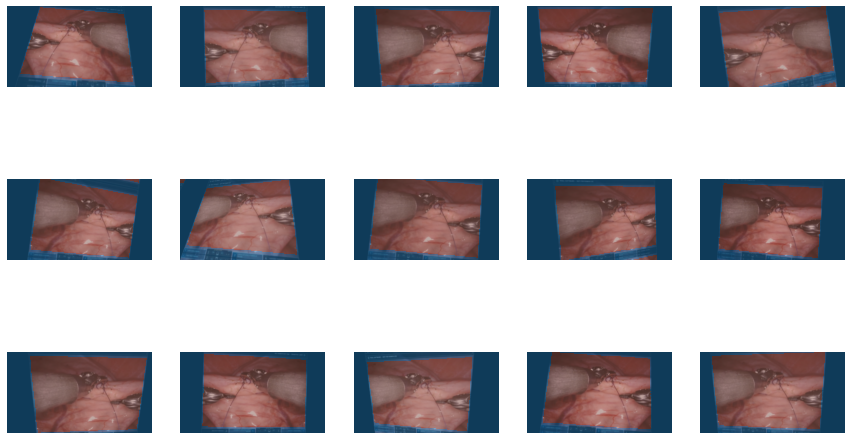

In [18]:
dls.show_batch(max_n=5,nrows=2,vmin=1, vmax=30, figsize=(14,10),unique=True)

## Baseline learner with default loss and opt functions

In [6]:
def custom_accuracy(inp, targ):
    targ = targ.squeeze(1)
    return (inp.argmax(dim=1)==targ).float().mean()

In [20]:
learn = unet_learner(dls,resnet34, self_attention=True, metrics=custom_accuracy).to_fp16()

SuggestedLRs(valley=4.365158383734524e-05)

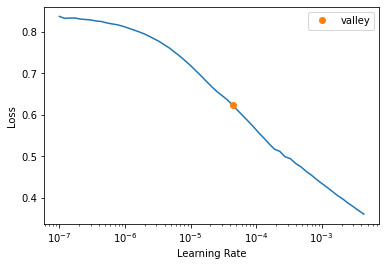

In [21]:
learn.lr_find()

In [22]:
learn.fine_tune(12,1e-3)

epoch,train_loss,valid_loss,custom_accuracy,time
0,0.035409,0.025518,0.991016,03:25


epoch,train_loss,valid_loss,custom_accuracy,time
0,0.025310,0.020022,0.992507,03:31
1,0.028419,0.019784,0.992702,03:31
2,0.022936,0.018289,0.993045,03:30
3,0.022383,0.018852,0.992863,03:31
4,0.021513,0.018702,0.992677,03:30
5,0.020439,0.016766,0.993491,03:31
6,0.020252,0.016755,0.993434,03:31
7,0.018431,0.016828,0.993547,03:30
8,0.017593,0.015554,0.993880,03:30
9,0.017437,0.015018,0.994118,03:30


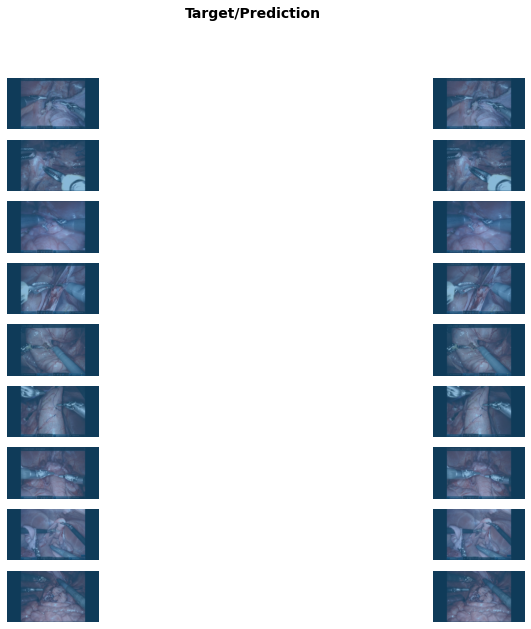

In [23]:
learn.show_results(vmin=1, vmax=30, figsize=(14,10))

In [24]:
learn.path=Path('models/seg')
learn.export('seg_v1.pkl')

In [25]:
preds, targs = learn.tta()

/home/bilal/mambaforge/lib/python3.9/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [26]:
preds.shape, targs.shape

(torch.Size([4913, 2, 180, 320]), torch.Size([4913, 180, 320]))

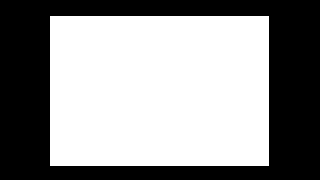

In [30]:
PILMask.create(np.array(targs[5]*255).astype(np.uint8))

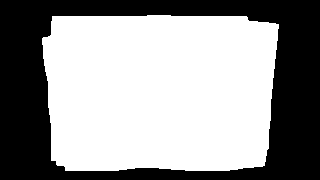

In [31]:
PILMask.create((np.array(preds[5].argmax(0))*255).astype(np.uint8))

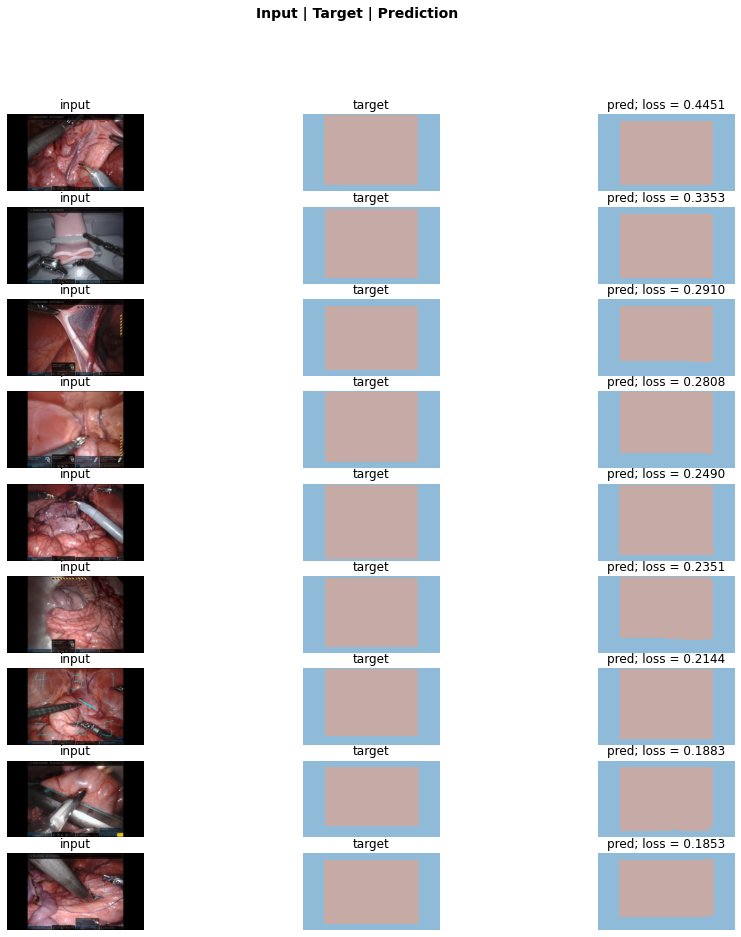

In [29]:
interp = SegmentationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
top_losses, top_idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,15))

## CrossEntropyFlat

In [28]:
learn = unet_learner(dls,resnet34, loss_func = CrossEntropyLossFlat(axis=1),self_attention=True, metrics=custom_accuracy).to_fp16()

SuggestedLRs(valley=6.30957365501672e-05)

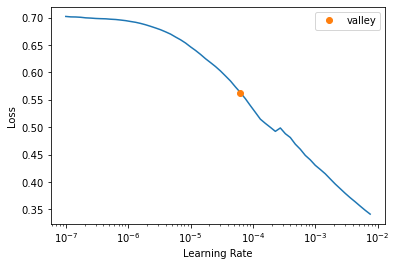

In [29]:
learn.lr_find()

In [30]:
learn.fine_tune(12,1e-2)

epoch,train_loss,valid_loss,custom_accuracy,time
0,0.885615,0.882867,0.673712,03:20


epoch,train_loss,valid_loss,custom_accuracy,time
0,0.890108,0.881028,0.673381,03:22
1,0.894896,0.891312,0.671064,03:23
2,0.890195,0.885008,0.672953,03:23
3,0.891139,0.883394,0.672919,03:23
4,0.893224,0.875213,0.675474,03:23
5,0.890622,0.877524,0.673997,03:23
6,0.891894,0.884482,0.673813,03:23
7,0.893360,0.886085,0.672722,03:23
8,0.894147,0.881590,0.673853,03:23
9,0.898528,0.884626,0.673558,03:23


In [31]:
learn.path=Path('models/seg')
learn.export('seg_celf_v1.pkl')

In [32]:
preds, targs = learn.tta()

/home/bilal/mambaforge/lib/python3.9/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


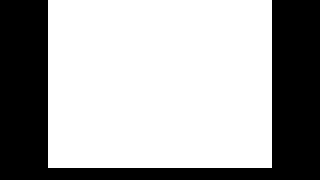

In [33]:
PILMask.create(np.array(targs[2000]*255).astype(np.uint8))

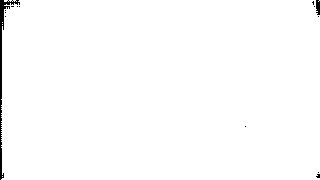

In [34]:
PILMask.create((np.array(preds[2000].argmax(0))*255).astype(np.uint8))

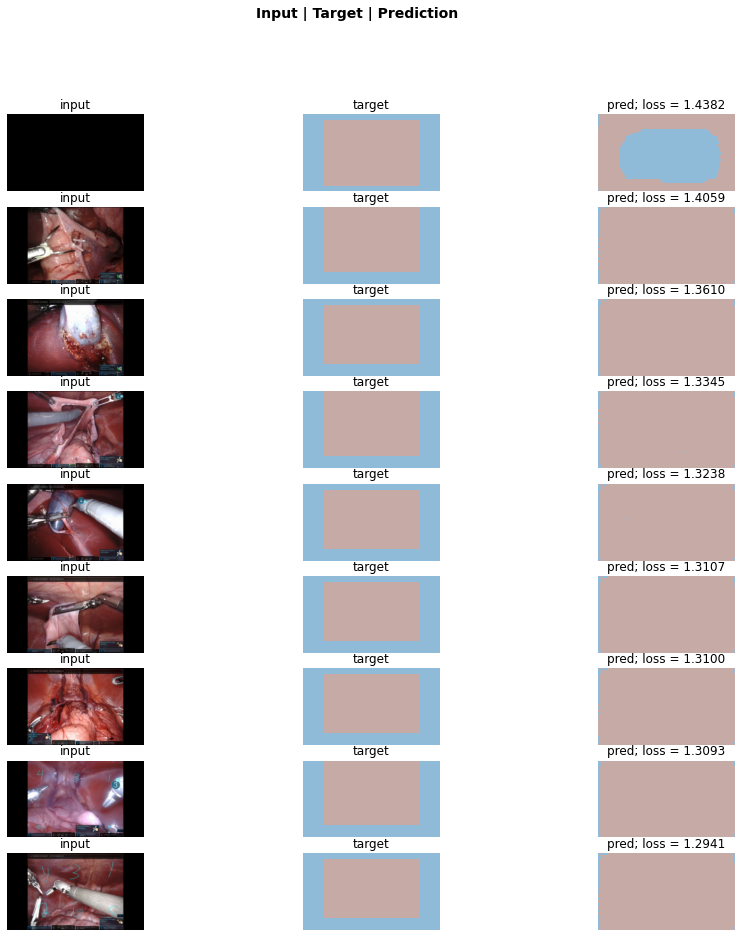

In [35]:
interp = SegmentationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
top_losses, top_idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,15))

## Ranger

In [36]:
opt = ranger
learn = unet_learner(dls,resnet34, loss_func = CrossEntropyLossFlat(axis=1),self_attention=True, act_cls=Mish, opt_func=opt, metrics=custom_accuracy).to_fp16()

SuggestedLRs(valley=3.0199516913853586e-05)

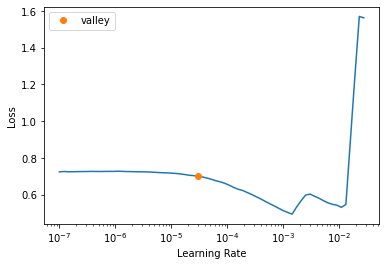

In [37]:
learn.lr_find()

In [40]:
lr=1e-4

In [41]:
learn.fit_flat_cos(12, slice(lr))

epoch,train_loss,valid_loss,custom_accuracy,time
0,nan,nan,0.654758,03:19
1,nan,nan,0.659340,03:19
2,nan,nan,0.659547,03:18
3,nan,nan,0.653042,03:19
4,nan,nan,0.664072,03:19
5,nan,nan,0.656801,03:19
6,nan,nan,0.671575,03:19
7,nan,nan,0.649935,03:19
8,nan,nan,0.661126,03:19
9,nan,nan,0.662797,03:19


In [42]:
learn.path=Path('models/seg')
learn.export('seg_ranger_v1.pkl')

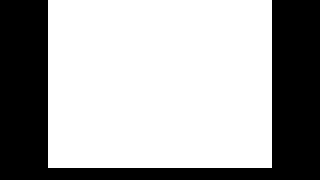

In [43]:
PILMask.create(np.array(targs[2000]*255).astype(np.uint8))

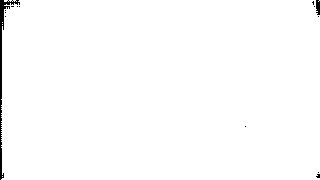

In [44]:
PILMask.create((np.array(preds[2000].argmax(0))*255).astype(np.uint8))

/home/bilal/mambaforge/lib/python3.9/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


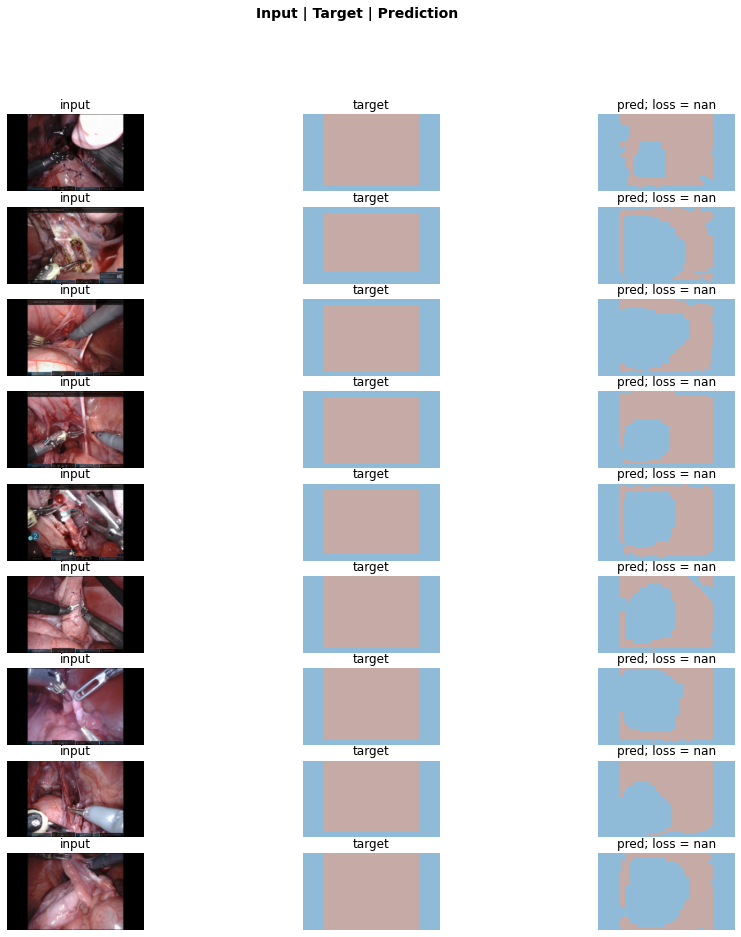

In [45]:
interp = SegmentationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
top_losses, top_idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,15))

# Using model for cropping images

In [7]:
# loading the best model
learn=load_learner('/home/bilal/mlworks/surgtoolloc/models/seg/seg_v1.pkl', cpu=False)

In [47]:
# define src and dst folders
src = Path().absolute()/'data/train_images'
dst = Path().absolute()/'data/train_images_c'
dst.mkdir(exist_ok=True)

In [44]:
# reading all images files
fs=get_image_files(src); len(fs)

2983454

In [45]:
# creating bunches for processing images
bunches = [i for i in range(len(fs)) if i%50000==0]

In [48]:
# for each bunch, predict masks and then use it to crop images
for i in range(len(bunches)):
    # setting start and end of a batch
    start=bunches[i]
    if not (i==len(bunches)-1):
        if bunches[i]==bunches[i+1]:
            end = len(bunches)
        else:
            end=bunches[i+1]
    else:
        end=len(fs)
    
    print(f'Predicting masks for images: {start} -> {end}.')
    preds,_ = learn.get_preds(dl=learn.dls.test_dl(fs[start:end]))
    
    print(f'Cropping and saving images: {start} -> {end}.')
    # for p, f in zip(preds,fs[start:end]):
    for p, f in zip(preds,learn.dl.items):
        dst_clip = dst/parent_label(f)
        dst_clip.mkdir(exist_ok=True)

        fn = f.name

        im=PILImage.create(f)
        (h,w)=im.shape
        mask=PILMask.create((np.array(p.argmax(0))*255).astype(np.uint8))
        mask=Resize((h,w), ResizeMethod.Squish) (mask)

        lbl = label(np.array(mask))
        props = regionprops(lbl)
        x1,y1,x2,y2=props[0].bbox[0],props[0].bbox[2],props[0].bbox[1],props[0].bbox[3]

        im_c = PILImage.create(np.array(im)[x1:y1,x2:y2])
        im_c.save(dst_clip/fn)


Predicting masks for images: 0 -> 50000.


Cropping and saving images: 0 -> 50000.
Predicting masks for images: 50000 -> 100000.


Cropping and saving images: 50000 -> 100000.
Predicting masks for images: 100000 -> 150000.


Cropping and saving images: 100000 -> 150000.
Predicting masks for images: 150000 -> 200000.


Cropping and saving images: 150000 -> 200000.
Predicting masks for images: 200000 -> 250000.


Cropping and saving images: 200000 -> 250000.
Predicting masks for images: 250000 -> 300000.


Cropping and saving images: 250000 -> 300000.
Predicting masks for images: 300000 -> 350000.


Cropping and saving images: 300000 -> 350000.
Predicting masks for images: 350000 -> 400000.


Cropping and saving images: 350000 -> 400000.
Predicting masks for images: 400000 -> 450000.


Cropping and saving images: 400000 -> 450000.
Predicting masks for images: 450000 -> 500000.


Cropping and saving images: 450000 -> 500000.
Predicting masks for images: 500000 -> 550000.


Cropping and saving images: 500000 -> 550000.
Predicting masks for images: 550000 -> 600000.


Cropping and saving images: 550000 -> 600000.
Predicting masks for images: 600000 -> 650000.


Cropping and saving images: 600000 -> 650000.
Predicting masks for images: 650000 -> 700000.


Cropping and saving images: 650000 -> 700000.
Predicting masks for images: 700000 -> 750000.


Cropping and saving images: 700000 -> 750000.
Predicting masks for images: 750000 -> 800000.


Cropping and saving images: 750000 -> 800000.
Predicting masks for images: 800000 -> 850000.


Cropping and saving images: 800000 -> 850000.
Predicting masks for images: 850000 -> 900000.


Cropping and saving images: 850000 -> 900000.
Predicting masks for images: 900000 -> 950000.


Cropping and saving images: 900000 -> 950000.
Predicting masks for images: 950000 -> 1000000.


Cropping and saving images: 950000 -> 1000000.
Predicting masks for images: 1000000 -> 1050000.


Cropping and saving images: 1000000 -> 1050000.
Predicting masks for images: 1050000 -> 1100000.


Cropping and saving images: 1050000 -> 1100000.
Predicting masks for images: 1100000 -> 1150000.


Cropping and saving images: 1100000 -> 1150000.
Predicting masks for images: 1150000 -> 1200000.


Cropping and saving images: 1150000 -> 1200000.
Predicting masks for images: 1200000 -> 1250000.


Cropping and saving images: 1200000 -> 1250000.
Predicting masks for images: 1250000 -> 1300000.


Cropping and saving images: 1250000 -> 1300000.
Predicting masks for images: 1300000 -> 1350000.


Cropping and saving images: 1300000 -> 1350000.
Predicting masks for images: 1350000 -> 1400000.


Cropping and saving images: 1350000 -> 1400000.
Predicting masks for images: 1400000 -> 1450000.


Cropping and saving images: 1400000 -> 1450000.
Predicting masks for images: 1450000 -> 1500000.


Cropping and saving images: 1450000 -> 1500000.
Predicting masks for images: 1500000 -> 1550000.


Cropping and saving images: 1500000 -> 1550000.
Predicting masks for images: 1550000 -> 1600000.


Cropping and saving images: 1550000 -> 1600000.
Predicting masks for images: 1600000 -> 1650000.


Cropping and saving images: 1600000 -> 1650000.
Predicting masks for images: 1650000 -> 1700000.


Cropping and saving images: 1650000 -> 1700000.
Predicting masks for images: 1700000 -> 1750000.


Cropping and saving images: 1700000 -> 1750000.
Predicting masks for images: 1750000 -> 1800000.


Cropping and saving images: 1750000 -> 1800000.
Predicting masks for images: 1800000 -> 1850000.


Cropping and saving images: 1800000 -> 1850000.
Predicting masks for images: 1850000 -> 1900000.


Cropping and saving images: 1850000 -> 1900000.
Predicting masks for images: 1900000 -> 1950000.


Cropping and saving images: 1900000 -> 1950000.
Predicting masks for images: 1950000 -> 2000000.


Cropping and saving images: 1950000 -> 2000000.
Predicting masks for images: 2000000 -> 2050000.


Cropping and saving images: 2000000 -> 2050000.
Predicting masks for images: 2050000 -> 2100000.


Cropping and saving images: 2050000 -> 2100000.
Predicting masks for images: 2100000 -> 2150000.


Cropping and saving images: 2100000 -> 2150000.
Predicting masks for images: 2150000 -> 2200000.


Cropping and saving images: 2150000 -> 2200000.
Predicting masks for images: 2200000 -> 2250000.


Cropping and saving images: 2200000 -> 2250000.
Predicting masks for images: 2250000 -> 2300000.


Cropping and saving images: 2250000 -> 2300000.
Predicting masks for images: 2300000 -> 2350000.


Cropping and saving images: 2300000 -> 2350000.
Predicting masks for images: 2350000 -> 2400000.


Cropping and saving images: 2350000 -> 2400000.
Predicting masks for images: 2400000 -> 2450000.


Cropping and saving images: 2400000 -> 2450000.
Predicting masks for images: 2450000 -> 2500000.


Cropping and saving images: 2450000 -> 2500000.
Predicting masks for images: 2500000 -> 2550000.


Cropping and saving images: 2500000 -> 2550000.
Predicting masks for images: 2550000 -> 2600000.


Cropping and saving images: 2550000 -> 2600000.
Predicting masks for images: 2600000 -> 2650000.


Cropping and saving images: 2600000 -> 2650000.
Predicting masks for images: 2650000 -> 2700000.


Cropping and saving images: 2650000 -> 2700000.
Predicting masks for images: 2700000 -> 2750000.


Cropping and saving images: 2700000 -> 2750000.
Predicting masks for images: 2750000 -> 2800000.


Cropping and saving images: 2750000 -> 2800000.
Predicting masks for images: 2800000 -> 2850000.


Cropping and saving images: 2800000 -> 2850000.
Predicting masks for images: 2850000 -> 2900000.


Cropping and saving images: 2850000 -> 2900000.
Predicting masks for images: 2900000 -> 2950000.


Cropping and saving images: 2900000 -> 2950000.
Predicting masks for images: 2950000 -> 2983454.


Cropping and saving images: 2950000 -> 2983454.


In [50]:
len(get_image_files(src))

2983454

In [51]:
len(get_image_files(dst))

2983454

In [49]:
assert len(get_image_files(src))==len(get_image_files(dst)), 'Not all images are cropped'